In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from __future__ import print_function

from pixyz.distributions import Normal, Bernoulli, Categorical
from pixyz.losses import KullbackLeibler, Expectation as E
from pixyz.models import Model
from pixyz.utils import print_latex

/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
#hyper-parameters
batch_size = 128
num_epochs = 100
learning_rate = 1e-3
seed = 1

In [4]:
root = "data/"
train_dataset = datasets.MNIST(root,
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
test_dataset = datasets.MNIST(root,
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              shuffle=False)

In [5]:
x_dim = 28*28
w_dim = 10
z_dim = 5

# q(z|x): image to z
class ImageEncoder(Normal):
    def __init__(self, x_dim, z_dim):
        super(ImageEncoder, self).__init__(var=["z"], cond_var=["x"], name="q")
        
        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3_1 = nn.Linear(512, z_dim)
        self.fc3_2 = nn.Linear(512, z_dim)
    
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc3_1(h), "scale": F.softplus(self.fc3_2(h))}


# q(z|w) digit to z
class DigitEncoder(Normal):
    def __init__(self, w_dim, z_dim):
        super(DigitEncoder, self).__init__(var=["z"], cond_var=["w"], name="q")
        
        self.fc1 = nn.Linear(w_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3_1 = nn.Linear(32, z_dim)
        self.fc3_2 = nn.Linear(32, z_dim)
    
    def forward(self, w):
        h = F.relu(self.fc1(w))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc3_1(h), "scale": F.softplus(self.fc3_2(h))}


# p(x|z)
class ImageDecoder(Bernoulli):
    def __init__(self, x_dim, z_dim):
        super(ImageDecoder, self).__init__(var=["x"], cond_var=["z"], name="p")
        
        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)
    
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}


# p(w|z)
class DigitDecoder(Categorical):
    def __init__(self, w_dim, z_dim):
        super(DigitDecoder, self).__init__(var=["w"], cond_var=["z"], name="p")
        
        self.fc1 = nn.Linear(z_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, w_dim)
    
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": F.softmax(self.fc3(h), dim=1)}


prior = Normal(var=["z"],
               loc=torch.tensor(0.),
               scale=torch.tensor(2.),
               features_shape=[z_dim],
               name="p_{prior}").to(device)

p_img = ImageDecoder(x_dim, z_dim).to(device)
p_digit = DigitDecoder(w_dim, z_dim).to(device)
q_img = ImageEncoder(x_dim, z_dim).to(device)
q_digit = DigitEncoder(w_dim, z_dim).to(device)

In [6]:
kl1 = KullbackLeibler(q_img, q_digit)
kl2 = KullbackLeibler(q_digit, q_img)
kl3 = KullbackLeibler(q_img, prior)
kl4 = KullbackLeibler(q_digit, prior)
reconst_img2img = -p_img.log_prob().expectation(q_img)
reconst_digit2img = -p_img.log_prob().expectation(q_digit)
reconst_img2digit = -p_digit.log_prob().expectation(q_img)
reconst_digit2digit = -p_digit.log_prob().expectation(q_digit)

# loss = (kl1 + kl3 + kl4 + reconst_img2img + reconst_digit2digit).mean()
# loss = (kl1 + kl2 + kl3 + kl4 + reconst_img2img + reconst_digit2digit).mean()
# loss = (kl1 + kl2 + kl3 + kl4 + reconst_digit2img + reconst_img2digit).mean()
loss = (kl1 + kl2 + 1 * (kl3 + kl4) + reconst_img2img + reconst_digit2img + reconst_img2digit + reconst_digit2digit).mean()
print_latex(loss)

<IPython.core.display.Math object>

In [7]:
model = Model(loss=loss,
              distributions=[p_img, p_digit, q_img, q_digit],
              optimizer=torch.optim.AdamW,
              optimizer_params={"lr": learning_rate})
print(model)
print_latex(model)

Distributions (for training):
  p(x|z), p(w|z), q(z|x), q(z|w)
Loss function:
  mean \left(D_{KL} \left[q(z|w)||p_{prior}(z) \right] + D_{KL} \left[q(z|w)||q(z|x) \right] + D_{KL} \left[q(z|x)||p_{prior}(z) \right] + D_{KL} \left[q(z|x)||q(z|w) \right] - \mathbb{E}_{q(z|w)} \left[\log p(w|z) \right] - \mathbb{E}_{q(z|w)} \left[\log p(x|z) \right] - \mathbb{E}_{q(z|x)} \left[\log p(w|z) \right] - \mathbb{E}_{q(z|x)} \left[\log p(x|z) \right] \right)
Optimizer:
  AdamW (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      capturable: False
      eps: 1e-08
      foreach: None
      lr: 0.001
      maximize: False
      weight_decay: 0.01
  )


<IPython.core.display.Math object>

In [8]:
def train(epoch):
    train_loss = 0
    for x, w in train_dataloader:
        x = x.to(device).view(-1, 28*28)
        w = torch.eye(10)[w].to(device)
        loss = model.train({"x": x, "w": w})
        train_loss += loss
    
    train_loss = train_loss * train_dataloader.batch_size / len(train_dataloader.dataset)
    print("Epoch[{}/{}], Train Loss: {:.4f}".format(epoch, num_epochs, train_loss))
    return train_loss

losses = []
for epoch in range(1, num_epochs + 1):
    losses.append(train(epoch))

Epoch[1/100], Train Loss: 397.9154
Epoch[2/100], Train Loss: 352.5542
Epoch[3/100], Train Loss: 345.5604
Epoch[4/100], Train Loss: 342.3319
Epoch[5/100], Train Loss: 340.5125
Epoch[6/100], Train Loss: 339.2039
Epoch[7/100], Train Loss: 337.9887
Epoch[8/100], Train Loss: 337.2811
Epoch[9/100], Train Loss: 336.4540
Epoch[10/100], Train Loss: 335.8807
Epoch[11/100], Train Loss: 335.3465
Epoch[12/100], Train Loss: 334.6805
Epoch[13/100], Train Loss: 334.5161
Epoch[14/100], Train Loss: 334.0949
Epoch[15/100], Train Loss: 333.8520
Epoch[16/100], Train Loss: 333.5498
Epoch[17/100], Train Loss: 333.2632
Epoch[18/100], Train Loss: 332.8514
Epoch[19/100], Train Loss: 332.8281
Epoch[20/100], Train Loss: 332.5675
Epoch[21/100], Train Loss: 332.4452
Epoch[22/100], Train Loss: 332.1283
Epoch[23/100], Train Loss: 332.1445
Epoch[24/100], Train Loss: 331.9043
Epoch[25/100], Train Loss: 331.7510
Epoch[26/100], Train Loss: 331.7149
Epoch[27/100], Train Loss: 331.5636
Epoch[28/100], Train Loss: 331.3955
E

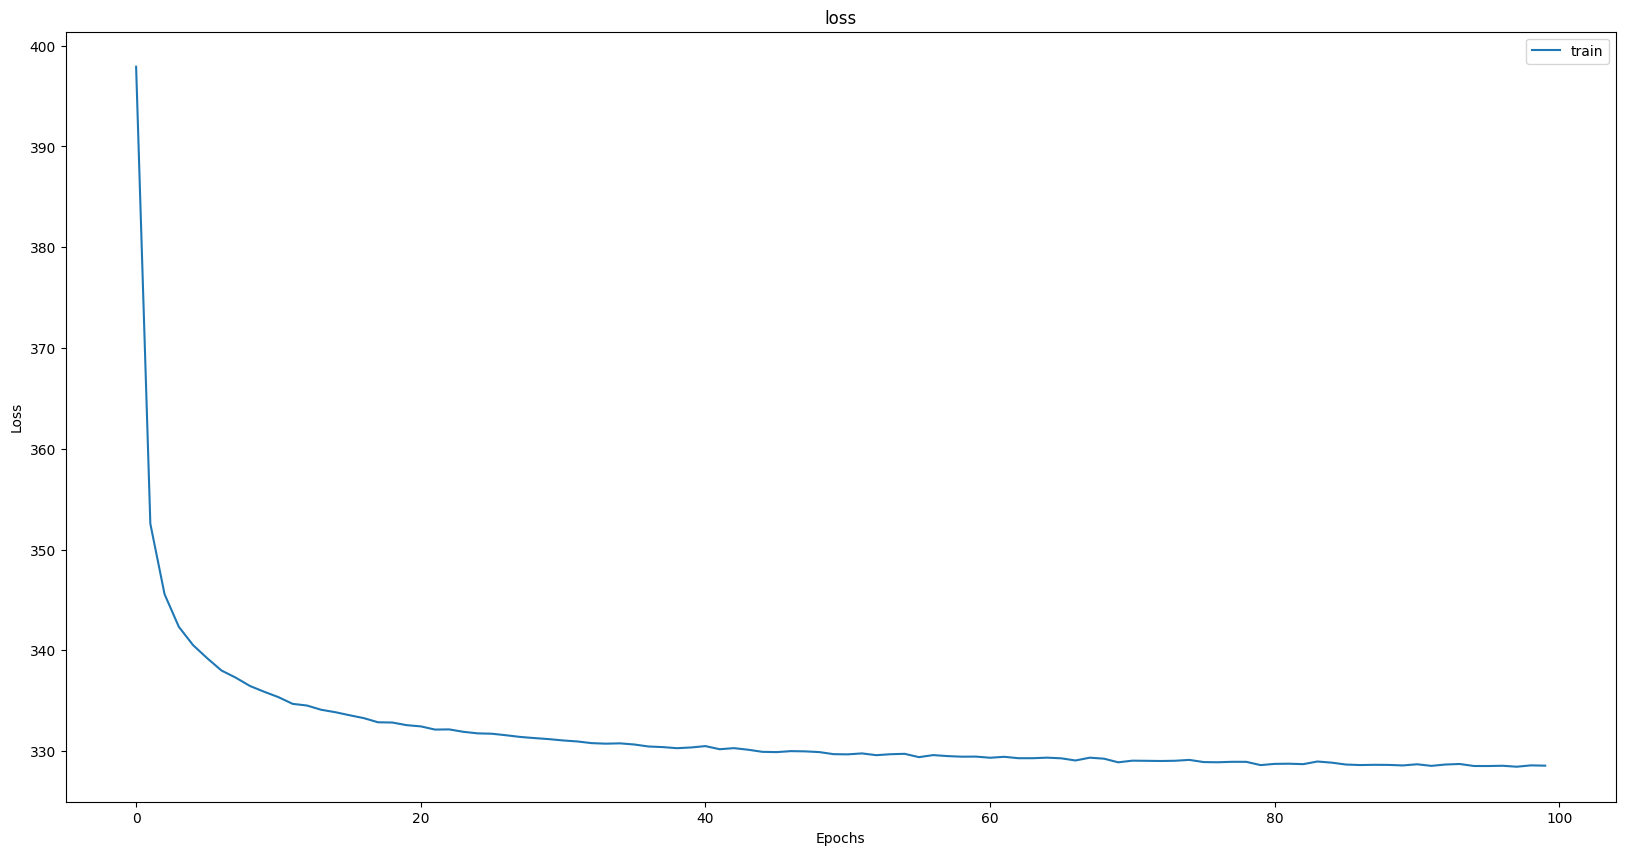

In [9]:
import matplotlib.pyplot as plt

losses = [x.tolist() for x in losses]

x = list(range(len(losses)))

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

ax.set_title("loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.plot(x, losses, label="train")
ax.legend()

plt.show()

In [10]:
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

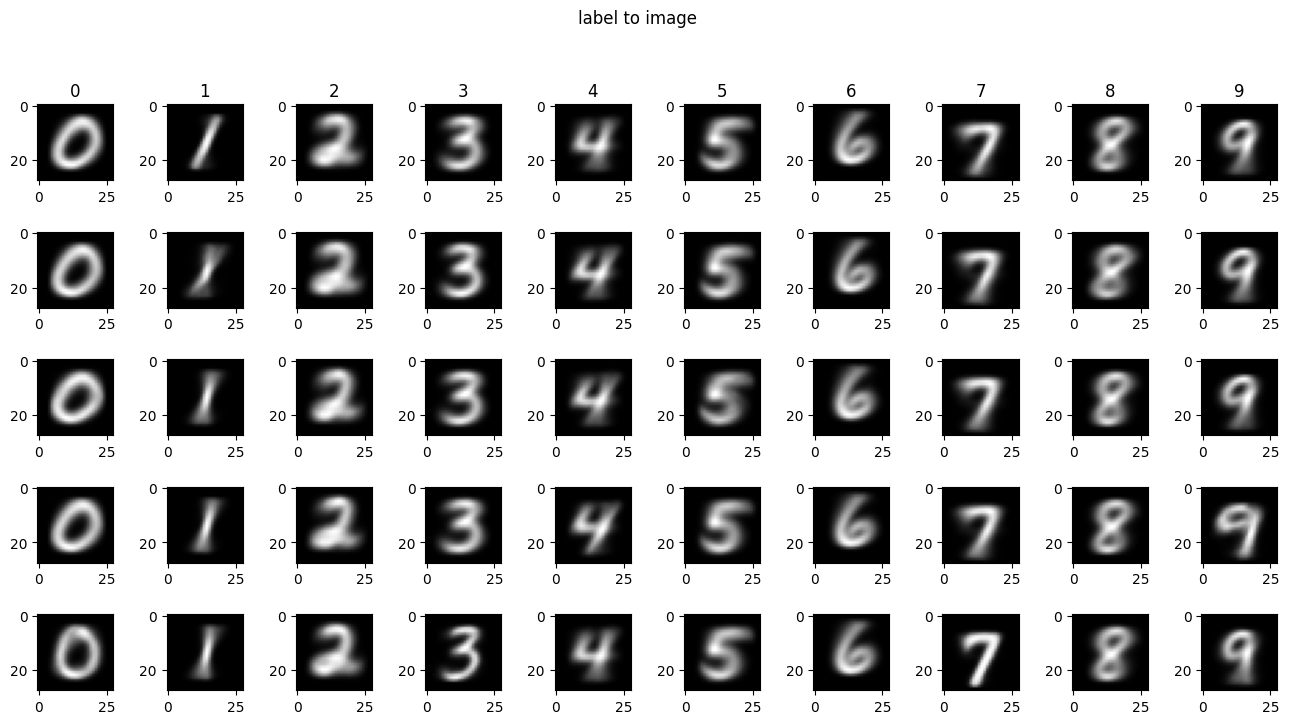

In [11]:
sample_n = 5

fig, ax = plt.subplots(sample_n, 10, figsize=(16, 8))
plt.subplots_adjust(wspace=0.7, hspace=0.2)
fig.suptitle("label to image")

test_iter = iter(test_dataloader)

with torch.no_grad():
    for i in range(10):
        ax[0, i].set_title(f"{i}")
        for n in range(sample_n):
            w = torch.eye(10)[i].to(device)
            z = q_digit.sample({"w": w}, return_all=False)
            recon_batch = p_img.sample_mean(z).view(-1,28,28).cpu()
            ax[n, i].imshow(np.transpose(recon_batch.numpy(), (1, 2, 0)), cmap="gray")
    plt.show()


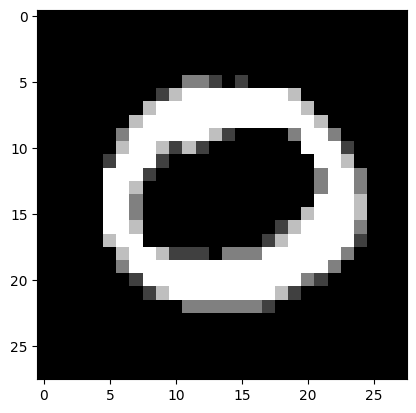

0


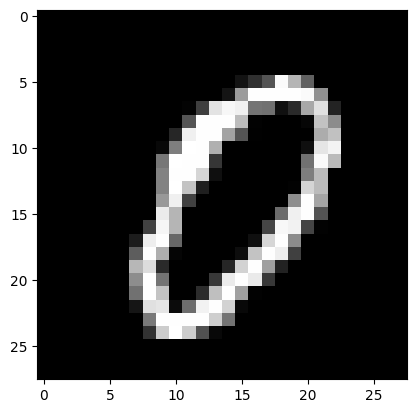

0


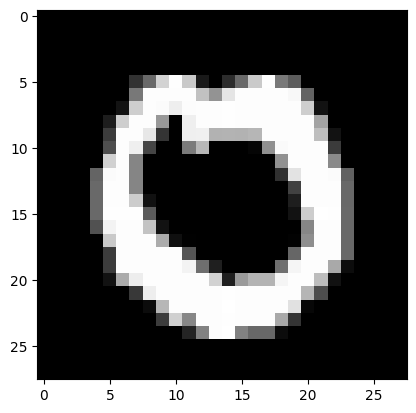

0


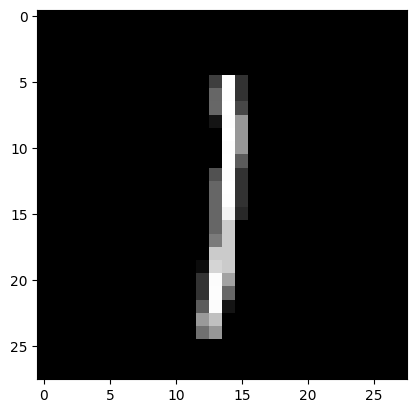

1


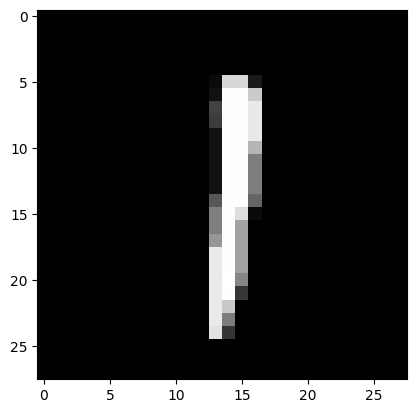

1


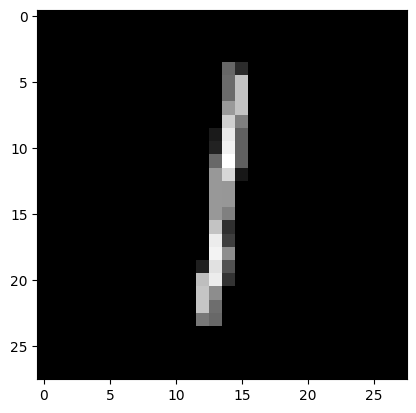

1


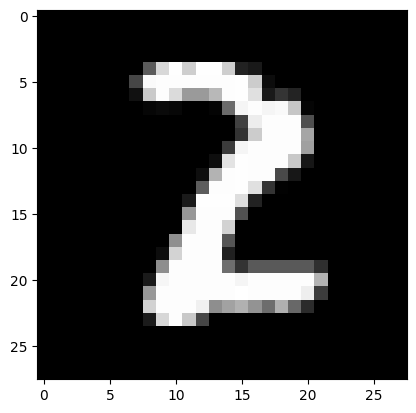

2


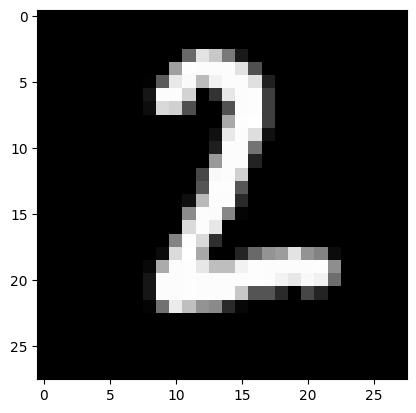

2


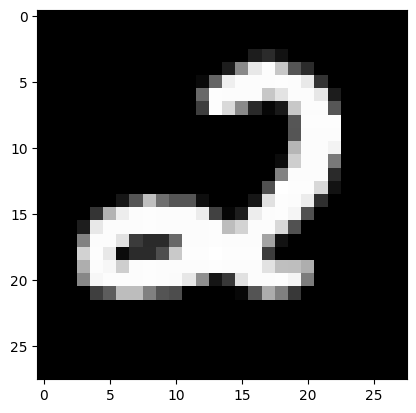

2


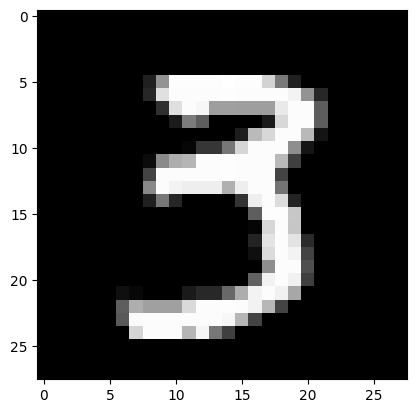

3


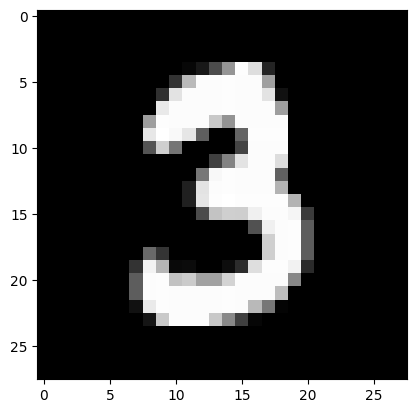

3


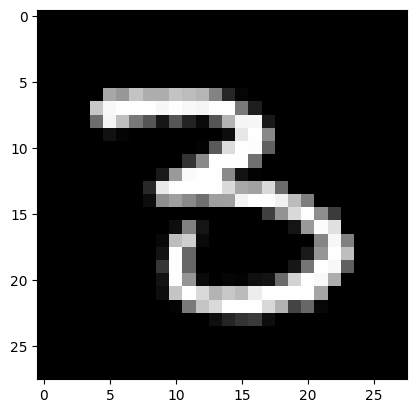

3


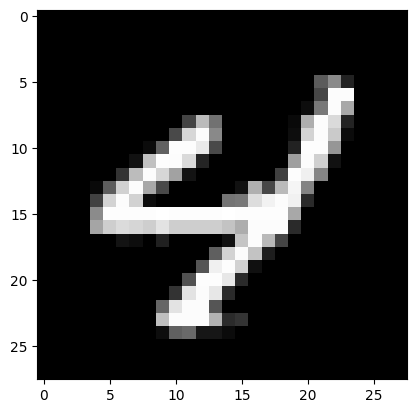

4


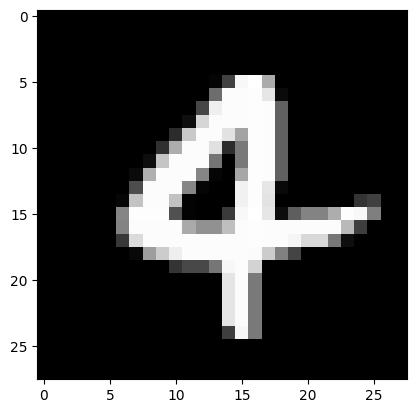

4


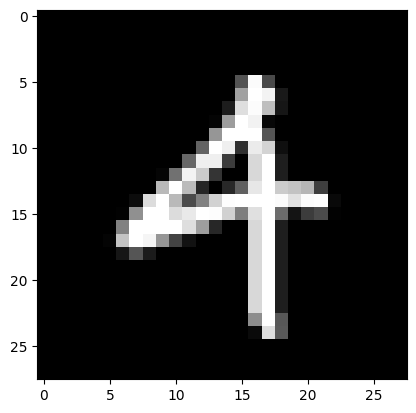

4


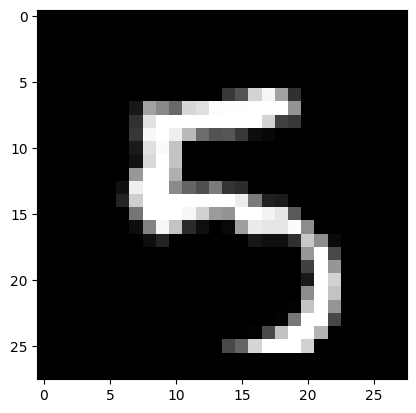

5


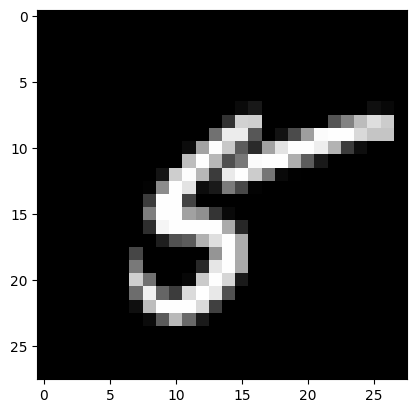

5


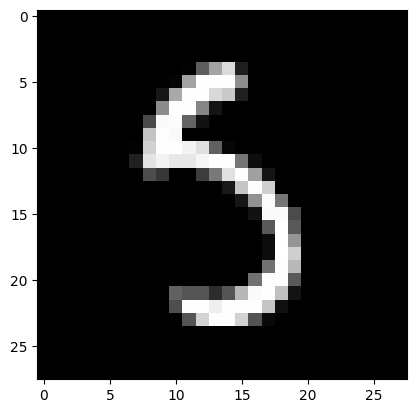

5


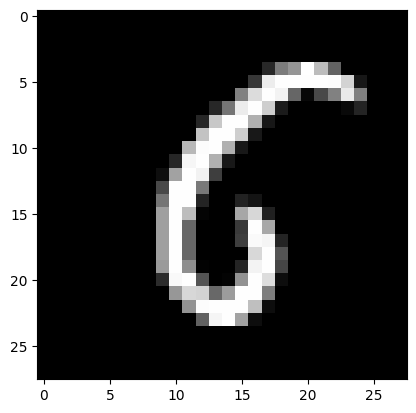

6


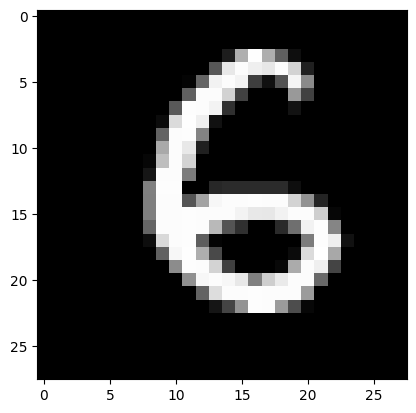

6


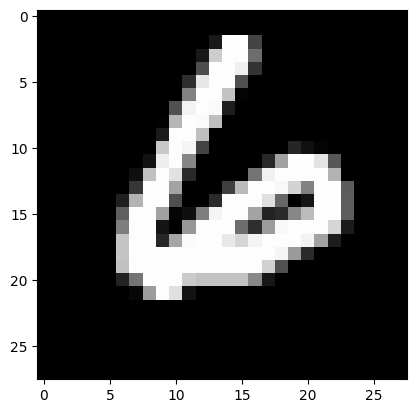

6


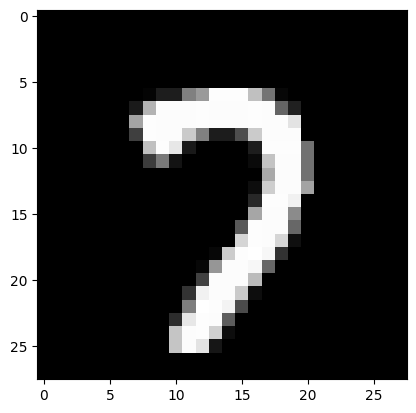

7


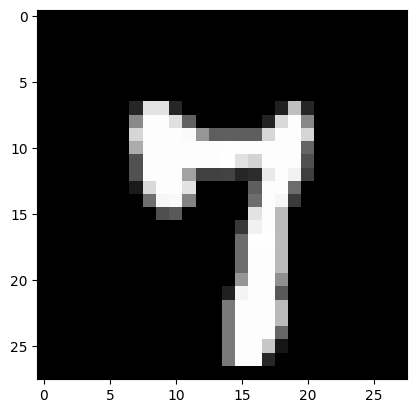

7


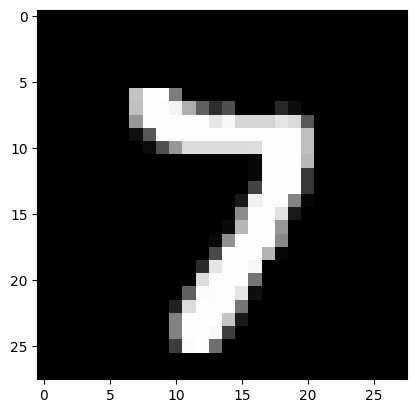

7


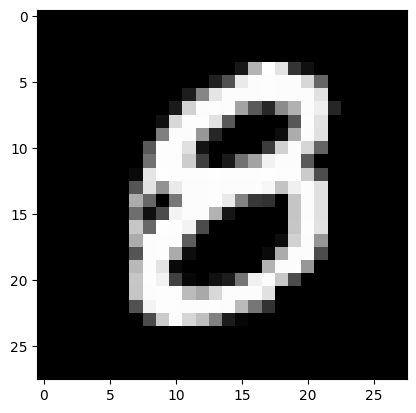

2


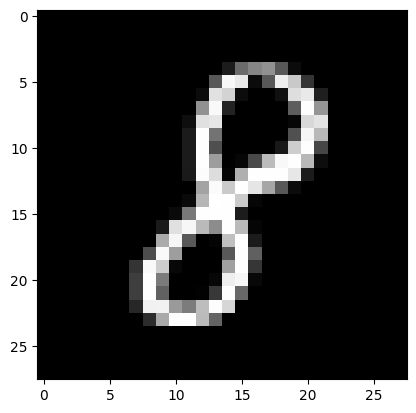

8


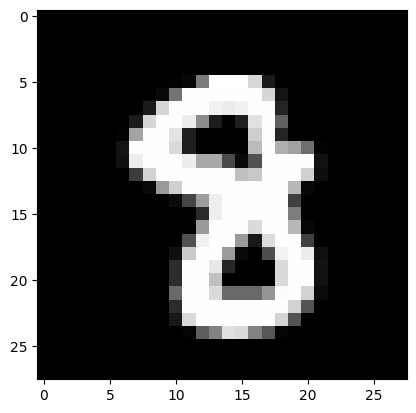

8


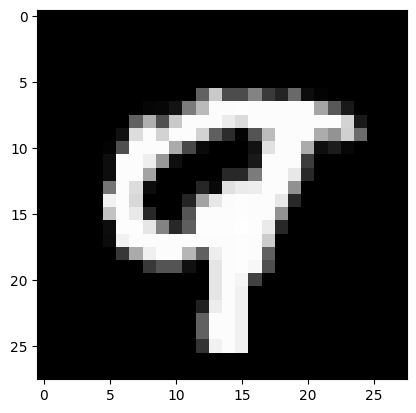

9


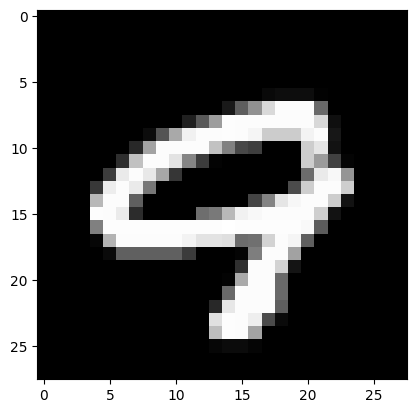

9


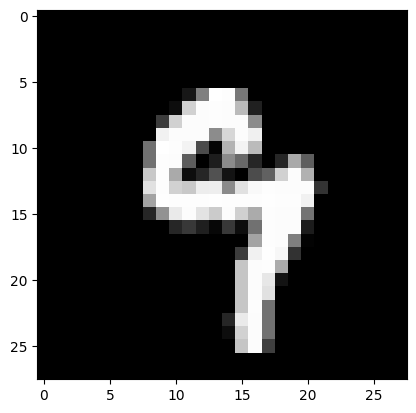

9


In [12]:
test_dataloaders = []
for i in range(10):
    dataset = datasets.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=True,)
    mask = (dataset.targets == i)
    dataset.data = dataset.data[mask]
    dataset.targets = dataset.targets[mask]
    dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=0)
    test_dataloaders.append(dataloader)

for dataloader in test_dataloaders:
    for i, (x, w) in enumerate(dataloader):
        x = x.to(device).view(-1, 28*28)
        z = q_img.sample({"x": x}, return_all=False)
        recon_batch = p_digit.sample_mean(z)
        res = torch.argmax(recon_batch, dim=1)
        imshow(x.view(-1,28,28).cpu())
        print(*res.tolist())
        if i == 2: break

(10000, 5)
(10000,)


/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


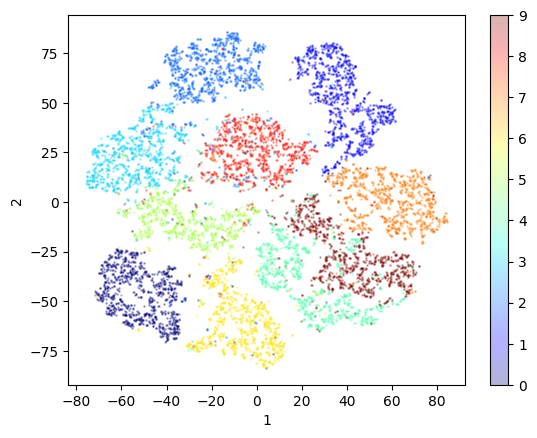

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.colors as colors

z_list = []
y_list = []

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.to(device).view(-1, 28*28)
        z = q_img.sample({"x": x}, return_all=False)
        z_list.append(z["z"])
        y_list.append(y)

z_list = torch.cat(z_list).cpu().numpy()
y_list = torch.cat(y_list).cpu().numpy()
print(z_list.shape)
print(y_list.shape)

tsne = TSNE(n_components=2)
z_list = tsne.fit_transform(z_list)

fig = plt.figure()
ax = fig.add_subplot()

ax.set_xlabel("1")
ax.set_ylabel("2")

for x, y in zip(z_list, y_list):
    mp = ax.scatter(x[0], x[1],
                    alpha=0.3,
                    c=y,
                    s=0.8,
                    vmin=0,
                    vmax=9,
                    cmap="jet")

fig.colorbar(mp, ax=ax)

plt.show()

(10000, 5)
10000


/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/nagailabpbl3/.local/share/virtualenvs/multimodal_generation-otsyb3SM/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


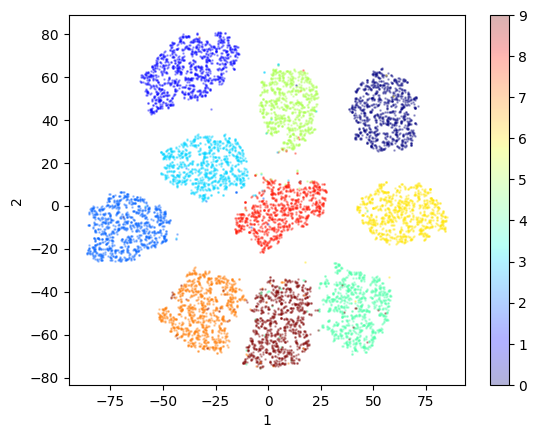

In [16]:
z_list = []
y_list = []

with torch.no_grad():
    for x, y in test_dataloader:
        y = y.tolist()
        w = torch.eye(10)[y].to(device)
        z = q_digit.sample({"w": w}, return_all=False)
        z_list.append(z["z"])
        y_list.append(y[0])

z_list = torch.cat(z_list).cpu().numpy()
# y_list = torch.cat(y_list).cpu().numpy()
print(z_list.shape)
print(len(y_list))

z_list = tsne.fit_transform(z_list)

fig = plt.figure()
ax = fig.add_subplot()

ax.set_xlabel("1")
ax.set_ylabel("2")

for x, y in zip(z_list, y_list):
    mp = ax.scatter(x[0], x[1],
                    alpha=0.3,
                    c=y,
                    s=0.8,
                    vmin=0,
                    vmax=9,
                    cmap="jet")

fig.colorbar(mp, ax=ax)

plt.show()